In [1]:
"""
Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20

Note (10/27/2022):
I would like to set up an ablation study to see the effect of the following hyper parameters
on the all-class and open-set (one vs rest) F1 scores:
    - C (number of dummy classifiers)
    - beta (l1 loss coefficient determining impact of masked probability)
"""

'\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n'

In [2]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tqdm import tqdm

In [3]:
NUM_CLASSES = 10
NUM_FEATURES = 784

def load_dataset():
    mndata = MNIST('/Users/jmmar/Google Drive/School/ASU/Fall 2022/EEE 598/HW2/data/')
    mndata.gz = True  # allows the use of the .gz compressed files
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, y_train = map(tensor, mndata.load_training())
    X_test, y_test = map(tensor, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return X_train, y_train, X_test, y_test

def validation_split(X, y, val_size=.2):
    """Input are expected to be tensors.
    """
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, X_val, y_train, y_val = map(tensor, train_test_split(X.numpy(), y.numpy()))
    return X_train, X_val, y_train, y_val

In [4]:
X, y, X_test, y_test = load_dataset()

In [5]:
def plot_training_metric(train_values, val_values, metric_name):
    iterations = list(range(len(train_values)))
    plt.plot(iterations, train_values, label='Train')
    plt.plot(iterations, val_values, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('{} While Training'.format(metric_name))
    plt.show()

In [6]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, pre_dim, post_dim, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim, activation='sigmoid', name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation='sigmoid', name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        logits = self.logits_layer(x_post)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [14]:
pre_dim = post_dim = 50
model = StandardLogisticRegressionModel(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES
)
model.compile(
    optimizer='adam', 
    loss=ce_loss, 
    metrics=[tfa.metrics.F1Score(name='f1', num_classes=NUM_CLASSES, average='macro')]
)
y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)
history = model.fit(X, y_train_one_hot, epochs=10, validation_split=.2)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7124 - f1: 0.8338 - val_loss: 0.2857 - val_f1: 0.9209
Epoch 2/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2429 - f1: 0.9301 - val_loss: 0.1986 - val_f1: 0.9443
Epoch 3/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1815 - f1: 0.9462 - val_loss: 0.1662 - val_f1: 0.9512
Epoch 4/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1483 - f1: 0.9552 - val_loss: 0.1498 - val_f1: 0.9556
Epoch 5/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1243 - f1: 0.9631 - val_loss: 0.1373 - val_f1: 0.9597
Epoch 6/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.1067 - f1: 0.9690 - val_loss: 0.1310 - val_f1: 0.9605
Epoch 7/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0927 - f1: 0.9731 - val_loss: 0.1257 - val_f1: 0.9599
Epoch 8/10
1500/1500 [==============================] - 2s 1ms/step - loss: 

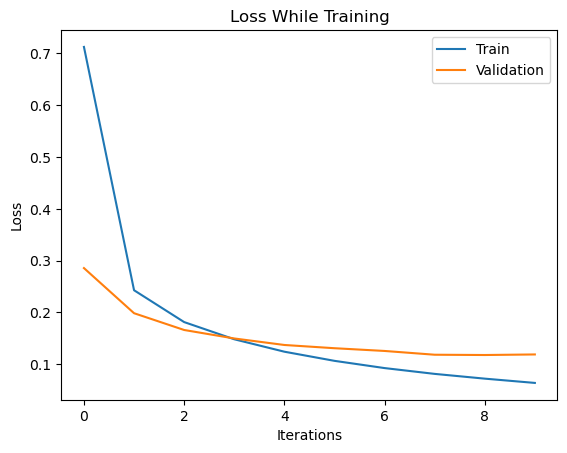

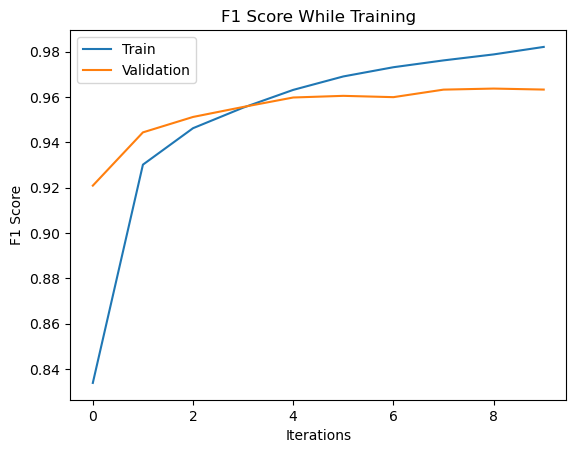

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_training_metric(train_loss, val_loss, 'Loss')

train_f1 = history.history['f1']
val_f1 = history.history['val_f1']
plot_training_metric(train_f1, val_f1, 'F1 Score')

In [7]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
    
def threshold_predict(X, model, threshold):
    y_pred = model.call(X)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = tf.reduce_all([y != label for label in class_labels], axis=0)
    y = tf.boolean_mask(y, to_remove_mask)
    X = tf.boolean_mask(X, to_remove_mask)
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

# def closed_set_accuracy(y_true, y_pred):
#     """ fraction of samples in the open set that are classified correctly.
#     """
#     y_true = tf.cast(y_true, tf.int64)
#     closed_set_idx = y_true != -1
#     return accuracy(y_true[closed_set_idx], y_pred[closed_set_idx])

def open_set_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.where(y_true == -1, 1, 0)
    y_pred = tf.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred)

# def closed_set_f1_score(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.int64)
#     closed_set_idx = y_true != -1
#     return f1_score(y_true[closed_set_idx], y_pred[closed_set_idx], average='macro')
    
def known_fraction(y_pred):
    """Fraction of predicted class labels != -1"""
    return tf.reduce_sum(tf.cast(y_pred != -1, tf.int64)) / y_pred.shape

Epoch 1/15
1014/1014 [==============================] - 2s 2ms/step - loss: 0.7297 - f1: 0.8310 - val_loss: 0.2898 - val_f1: 0.9191
Epoch 2/15
1014/1014 [==============================] - 2s 1ms/step - loss: 0.2461 - f1: 0.9308 - val_loss: 0.1998 - val_f1: 0.9394
Epoch 3/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.1802 - f1: 0.9492 - val_loss: 0.1580 - val_f1: 0.9534
Epoch 4/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.1414 - f1: 0.9596 - val_loss: 0.1293 - val_f1: 0.9596
Epoch 5/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.1154 - f1: 0.9669 - val_loss: 0.1114 - val_f1: 0.9639
Epoch 6/15
1014/1014 [==============================] - 2s 1ms/step - loss: 0.0963 - f1: 0.9723 - val_loss: 0.1029 - val_f1: 0.9667
Epoch 7/15
1014/1014 [==============================] - 1s 1ms/step - loss: 0.0813 - f1: 0.9769 - val_loss: 0.0968 - val_f1: 0.9690
Epoch 8/15
1014/1014 [==============================] - 1s 1ms/step - loss: 

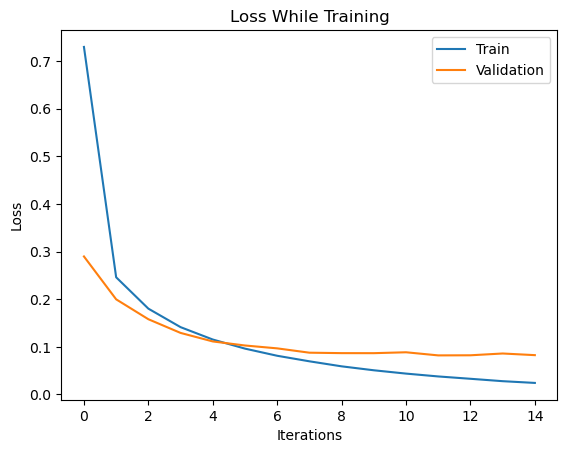

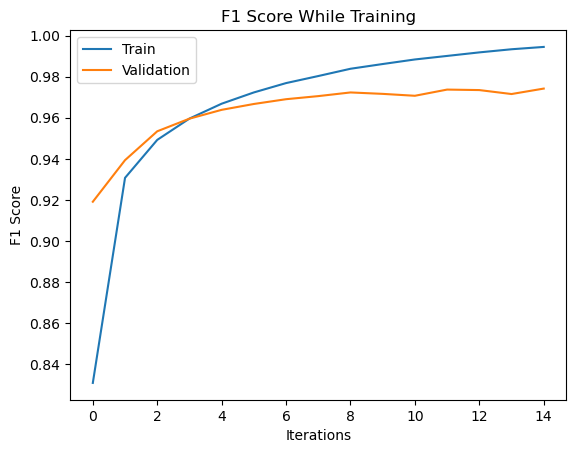

In [38]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

pre_dim = post_dim = 50
model = StandardLogisticRegressionModel(pre_dim, post_dim, NUM_CLASSES - 1)
model.compile(
    optimizer='adam', 
    loss=ce_loss, 
    metrics=[tfa.metrics.F1Score(name='f1', num_classes=NUM_CLASSES - 1, average='macro')]
)
y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes)
history = model.fit(X_train_closed, y_train_one_hot, epochs=15, validation_split=.2)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_training_metric(train_loss, val_loss, 'Loss')

train_f1 = history.history['f1']
val_f1 = history.history['val_f1']
plot_training_metric(train_f1, val_f1, 'F1 Score')

In [8]:
def tune_model_param(model, val_closed, val_open, param_values, param_name, predict_func,
                     objective_func, target_value, objective_name, metrics, plot=True):
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val, open_set_class_labels)
    best_objective_error = float('inf')
    best_param_value = 0
    objective_values = []
    metric_values = {metric: [] for metric in metrics}
    for param_value in param_values:
        y_pred_closed = predict_func(val_closed['X'], model, param_value)
        y_pred_open = predict_func(val_open['X'], model, param_value)
        objective_values.append(objective_func(y_pred_closed))
        objective_error = float(abs(objective_values[-1] - target_value))
        if objective_error < best_objective_error:
            best_objective_error = objective_error
            best_param_value = param_value
        for metric in metrics:
            metric_values[metric].append(metrics[metric](val_open['y'], y_pred_open))
    if plot:
        for metric in metrics:
            plt.plot(param_values, metric_values[metric], label=metric)
        plt.plot(param_values, objective_values, label=objective_name)
        plt.xlabel(param_name)
        plt.legend()
        plt.title('Calibrating {}'.format(param_name))
        plt.show()
    return best_param_value

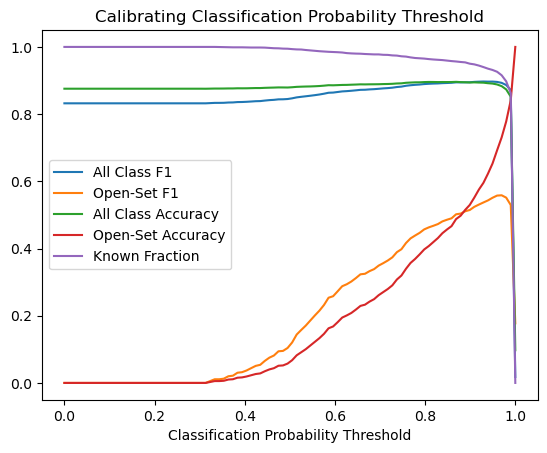

Results from test set using 95% threshold (0.8990):
All Class F1: 0.9043
Open-Set F1: 0.5522
All Class Accuracy: 0.9028
Open-Set Accuracy: 0.5481


In [40]:
# See how the threshold value affects accuracy and find the threshold
# such that 95% of validation data is recognized as known

threshold_values = np.linspace(0, 1, 100)
target_known_fraction = .95

metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

# split validation set into an open validation set and a closed validation set
X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
# remove open-set samples from the closed-set validation data
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)

val_closed = {'X': X_val_closed, 'y': y_val_closed}
val_open = {'X': X_val_open, 'y': y_val_open}

param_name = 'Classification Probability Threshold'
objective_name = 'Known Fraction'
threshold = tune_model_param(
    model, val_closed, val_open, threshold_values, param_name, threshold_predict,
    known_fraction, target_known_fraction, objective_name, metrics, plot=True
)

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = threshold_predict(X_test, model, threshold)
print('Results from test set using 95% threshold ({:.4f}):'.format(threshold))
for metric in metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [10]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')
        self.bias = 0 # used to calibrate dummy logit to have same magnitude as rest of logits

    def _pre(self, inputs):
        return self.embed_pre(inputs)
    
    def _rest(self, inputs):
        x_post = self.embed_post(inputs)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
        return self.output_layer(all_logits)
        
    def call(self, inputs):
        x_pre = self._pre(inputs)
        return self._rest(x_pre)
        
#     def call(self, inputs):
#         x_pre = self.embed_pre(inputs)
#         x_post = self.embed_post(x_pre)
#         closed_set_logits = self.logits_layer(x_post)
#         dummy_logits = self.dummy_logits_layer(x_post)
#         max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
#         all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
#         return self.output_layer(all_logits)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.call(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)    
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss

Epoch 1/25
1013/1013 [==============================] - 2s 2ms/step - loss: 1.8631 - f1: 0.5693 - val_loss: 1.4605 - val_f1: 0.7359
Epoch 2/25
1013/1013 [==============================] - 2s 2ms/step - loss: 1.3975 - f1: 0.7714 - val_loss: 1.3657 - val_f1: 0.7893
Epoch 3/25
1013/1013 [==============================] - 2s 2ms/step - loss: 1.3251 - f1: 0.8043 - val_loss: 1.3252 - val_f1: 0.8129
Epoch 4/25
1013/1013 [==============================] - 2s 2ms/step - loss: 1.2844 - f1: 0.8229 - val_loss: 1.2901 - val_f1: 0.8277
Epoch 5/25
1013/1013 [==============================] - 2s 2ms/step - loss: 1.2577 - f1: 0.8353 - val_loss: 1.2773 - val_f1: 0.8331
Epoch 6/25
1013/1013 [==============================] - 2s 2ms/step - loss: 1.2376 - f1: 0.8423 - val_loss: 1.2609 - val_f1: 0.8420
Epoch 7/25
1013/1013 [==============================] - 2s 2ms/step - loss: 1.2217 - f1: 0.8484 - val_loss: 1.2518 - val_f1: 0.8460
Epoch 8/25
1013/1013 [==============================] - 2s 2ms/step - loss: 

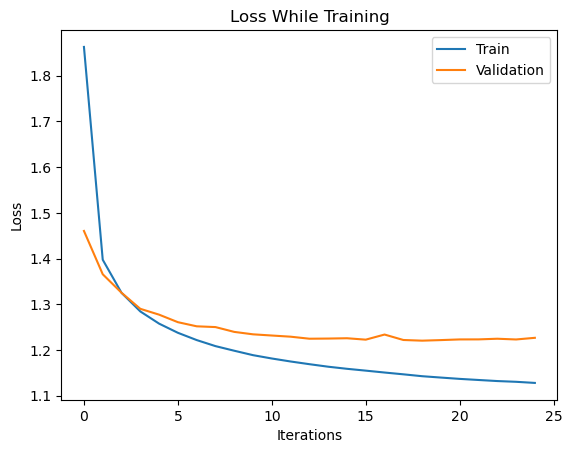

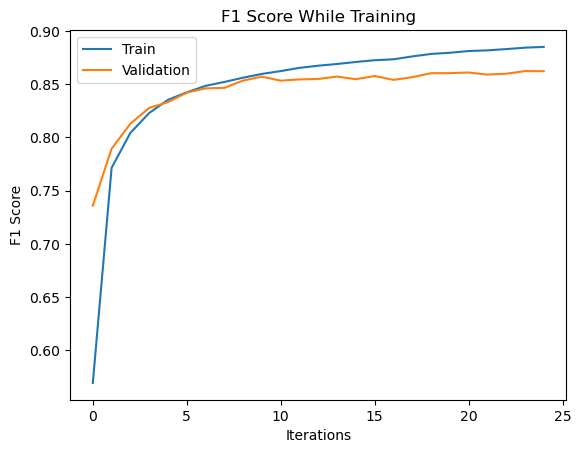

In [93]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

num_placeholders = 20
pre_dim = post_dim = 50
model = OpenSetPlaceholdersLRM(
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES - 1,
    num_placeholders=num_placeholders
)
beta = .65
loss = lambda *x: ce_loss_for_placeholders(*x, beta)
model.compile(
    optimizer='adam', 
    loss=loss, 
    metrics=[tfa.metrics.F1Score(name='f1', num_classes=NUM_CLASSES, average='macro')]
)
# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
history = model.fit(X_train_closed, y_train_one_hot, epochs=25, validation_split=.2, batch_size=32)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plot_training_metric(train_loss, val_loss, 'Loss')

train_f1 = history.history['f1']
val_f1 = history.history['val_f1']
plot_training_metric(train_f1, val_f1, 'F1 Score')

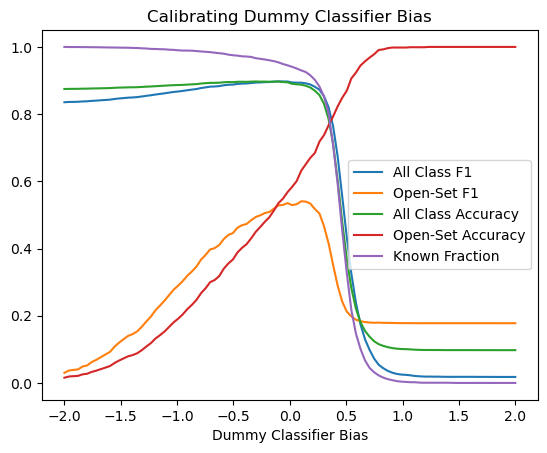

Results from test set using 95% bias (-0.0606):
All Class F1: 0.9004
Open-Set F1: 0.5476
All Class Accuracy: 0.8981
Open-Set Accuracy: 0.5590


In [94]:
# See how the bias value affects accuracy and find the bias
# such that 95% of validation data is recognized as known

def placeholders_predict(X, model, bias):
    model.bias = bias
    return model.predict(X)

target_known_fraction = .95
bias_values = np.linspace(-2, 2, 100)

metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

# split validation set into an open validation set and a closed validation set
X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
# remove open-set samples from the closed-set validation data
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)

val_closed = {'X': X_val_closed, 'y': y_val_closed}
val_open = {'X': X_val_open, 'y': y_val_open}

param_name = 'Dummy Classifier Bias'
objective_name = 'Known Fraction'
bias = tune_model_param(
    model, val_closed, val_open, bias_values, param_name, placeholders_predict,
    known_fraction, target_known_fraction, objective_name, metrics, plot=True
)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [89]:
### THE CODE BELOW IS A WORK IN PROGRESS AND DOES NOT CURRENTLY RUN ###


"""We will now introduce data placeholders. In essence, we will be synthesizing open-set training
data via a process called "manifold mixup". We will also introduce a new loss function which makes
use of the new synthetic data.
"""

# Open set placeholder
class OSPWithDataPlaceholdersLRM(OpenSetPlaceholdersLRM):
    def __init__(self, alpha, beta, gamma, optimizer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.optimizer = optimizer
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    @tf.function
    def train_step(self, X, y_true, metrics):
        X_part1, X_part2 = tf.split(X, 2)
        y_true_part1, y_true_part2 = tf.split(y_true, 2)
        
        # create a new y_true where the true label is the open-set class
        rows, cols = y_true_part2.shape
        rows = rows or 1
        y_true_new = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
        
        with tf.GradientTape() as tape:
            # caldulate the first portion of the loss on the first half of the batch
            y_pred_part1 = self.call(X_part1)
            loss1 = ce_loss_for_placeholders(y_true_part1, y_pred_part1, self.beta)
            # perform manifold mixup and calculate the second part of the loss
            X_part2_pre = self._pre(X_part2)
            X_part2_pre_hat = self.manifold_mixup(X_part2_pre)
            y_pred_part2 = self._rest(X_part2_pre_hat)
            loss2 = ce_loss(y_true_new, y_pred_part2)
            # calculated weighted sum of losses
            loss = loss1 + self.gamma * loss2
            #print('l1: {} l2: {} loss: {}'.format(float(loss1), float(loss2), float(loss)))
            
        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics using the predictions from batch part 1
        for m_name in metrics:
            metrics[m_name].update_state(y_true_part1, y_pred_part1)
        return loss
    
    def fit(self, X, y, epochs, val_size, batch_size, metrics):
        X_train, X_val, y_train, y_val = validation_split(X, y, val_size)
        # cut train set down to a multiple of batch_size
        num_batches = len(X_train) // batch_size
        X_train = X_train[:num_batches * batch_size]
        y_train = y_train[:num_batches * batch_size]
                
        # split training data into batches
        X_train_batches = tf.split(X_train, len(X_train) // batch_size)
        y_train_batches = tf.split(y_train, len(y_train) // batch_size)
        
        val_prefix = 'val_'
        metric_results = dict()
        for m_name in metrics:
            metric_results[m_name] = []
            metric_results[val_prefix + m_name] = []
        metric_results['loss'] = []
        
        for epoch in range(1, epochs + 1):
            print('Epoch {}/{}'.format(epoch, epochs))
            for m_name in metrics:
                metrics[m_name].reset_states()
            for X_batch, y_batch in tqdm(zip(X_train_batches, y_train_batches), total=len(X_train_batches)):
                loss = self.train_step(X_batch, y_batch, metrics)
            for m_name in metrics:
                metric_results[m_name].append(metrics[m_name].result())
            # calculate validation metrics
            for m_name in metrics:
                metrics[m_name].reset_states()
                y_pred = self.call(X_val)
                metrics[m_name].update_state(y_val, y_pred)
                metric_results[val_prefix + m_name].append(metrics[m_name].result())
            metric_results['loss'].append(loss)
            status_message = ' '.join(
                ['{}: {:.3f}'.format(m,r[-1]) for m,r in metric_results.items()]
            )
            #print(status_message)
        return metric_results
    
    def manifold_mixup(self, X_pre):
        """
        """
        alpha = tf.constant(self.alpha)
        dist = tfp.distributions.Beta(alpha, alpha)
        lam = dist.sample(1)
        indices = tf.random.shuffle(tf.range(X_pre.shape[0]))
        X_pre_hat = lam * X_pre + (1 - lam) * tf.gather(X_pre, indices)
        return X_pre_hat

(30400, 784)
Epoch 1/50


100%|███████████████████████████████████████████████████████████████████████████████| 475/475 [00:01<00:00, 409.11it/s]


Epoch 2/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1085.27it/s]


Epoch 3/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1058.00it/s]


Epoch 4/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1028.74it/s]


Epoch 5/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1078.73it/s]


Epoch 6/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1092.61it/s]


Epoch 7/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1024.24it/s]


Epoch 8/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1052.26it/s]


Epoch 9/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1014.72it/s]


Epoch 10/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1049.06it/s]


Epoch 11/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1035.37it/s]


Epoch 12/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1030.11it/s]


Epoch 13/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1065.49it/s]


Epoch 14/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1037.63it/s]


Epoch 15/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1054.41it/s]


Epoch 16/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1025.83it/s]


Epoch 17/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1008.06it/s]


Epoch 18/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1005.79it/s]


Epoch 19/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1009.51it/s]


Epoch 20/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1019.85it/s]


Epoch 21/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1031.67it/s]


Epoch 22/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1010.50it/s]


Epoch 23/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1032.19it/s]


Epoch 24/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1015.50it/s]


Epoch 25/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1026.65it/s]


Epoch 26/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1010.84it/s]


Epoch 27/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1049.05it/s]


Epoch 28/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1088.94it/s]


Epoch 29/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1088.20it/s]


Epoch 30/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1087.23it/s]


Epoch 31/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1075.10it/s]


Epoch 32/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1092.85it/s]


Epoch 33/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1088.48it/s]


Epoch 34/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1097.40it/s]


Epoch 35/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1064.43it/s]


Epoch 36/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1045.35it/s]


Epoch 37/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1040.43it/s]


Epoch 38/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1077.88it/s]


Epoch 39/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1056.62it/s]


Epoch 40/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1062.58it/s]


Epoch 41/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1084.90it/s]


Epoch 42/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1076.39it/s]


Epoch 43/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1047.37it/s]


Epoch 44/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1028.66it/s]


Epoch 45/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1056.04it/s]


Epoch 46/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1087.08it/s]


Epoch 47/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1096.49it/s]


Epoch 48/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1092.36it/s]


Epoch 49/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1039.55it/s]


Epoch 50/50


100%|██████████████████████████████████████████████████████████████████████████████| 475/475 [00:00<00:00, 1077.42it/s]


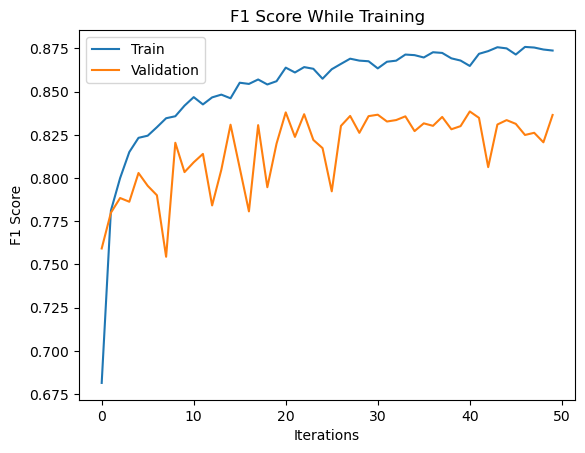

In [99]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

num_placeholders = 20
pre_dim = post_dim = 50
alpha = 2.0
beta = .65
gamma = .1
model = OSPWithDataPlaceholdersLRM(
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    pre_dim=pre_dim, 
    post_dim=post_dim, 
    num_classes=NUM_CLASSES - 1,
    num_placeholders=num_placeholders,
)

metrics = {
    'f1': tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro')
}

# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
metric_results = model.fit(
    X_train_closed, 
    y_train_one_hot, 
    epochs=50, 
    val_size=.2, 
    batch_size=64,
    metrics=metrics,
)


train_f1 = metric_results['f1']
val_f1 = metric_results['val_f1']
plot_training_metric(train_f1, val_f1, 'F1 Score')

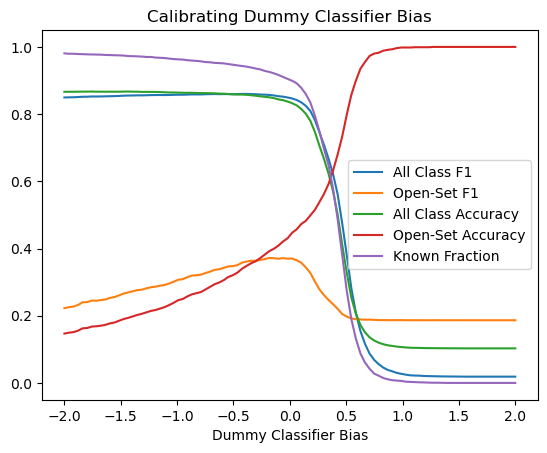

Results from test set using 95% bias (-0.5859):
All Class F1: 0.8587
Open-Set F1: 0.3189
All Class Accuracy: 0.8617
Open-Set Accuracy: 0.2775


In [100]:
target_known_fraction = .95
bias_values = np.linspace(-2, 2, 100)

metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

# split validation set into an open validation set and a closed validation set
X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
# remove open-set samples from the closed-set validation data
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)

val_closed = {'X': X_val_closed, 'y': y_val_closed}
val_open = {'X': X_val_open, 'y': y_val_open}

param_name = 'Dummy Classifier Bias'
objective_name = 'Known Fraction'
bias = tune_model_param(
    model, val_closed, val_open, bias_values, param_name, placeholders_predict,
    known_fraction, target_known_fraction, objective_name, metrics, plot=True
)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

y_pred = model.predict(X_test)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in metrics:
    metric_func = metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))